### Set MLRun environment

In [1]:
from mlrun import set_environment
import pandas as pd
from os import path

# Set the default environment configuration
project_name_base = "fraud-detection-demo"
project_name, artifact_path = set_environment(project=project_name_base,
                                              artifact_path="/User/artifacts/{{run.project}}/{{workflow.uid}}")

### Define Feature Transformations

In [2]:
import storey
from typing import List, Dict
class DropColumns(storey.MapClass):
    def __init__(self, columns: List[str], **kwargs):
        super().__init__(**kwargs)
        self.columns = columns

    def do(self, event):
        for col in self.columns:
            if col in event:
                del event[col]
        return event

    def to_dict(self):
        return {
            "class_name": "DropColumns",
            "name": self.name or "DropColumns",
            "class_args": {"columns": self.columns}
        }

class RenameColumns(storey.MapClass):
    def __init__(self, mapping: Dict[str, str], **kwargs):
        super().__init__(**kwargs)
        self.mapping = mapping

    def do(self, event):
        for old_col, new_col in self.mapping.items():
            try:
                event[new_col] = event.pop(old_col)
            except Exception as e:
                print(f'{old_col} doesnt exist')
        return event

    def to_dict(self):
        return {
            "class_name": "RenameColumns",
            "name": self.name or "RenameColumns",
            "class_args": {"mapping": self.mapping},
        }
    
class SetColumnsByCondition(storey.MapClass):
    def __init__(self, mapping: Dict[str, str], **kwargs):
        super().__init__(**kwargs)
        self.mapping = mapping

    def do(self, event):
        if eval(self.mapping["condition"]):
            for col in self.mapping["target_columns"]:
                event[col] = self.mapping["target_value"]
        return event

    def to_dict(self):
        return {
            "class_name": "SetColumnsByCondition",
            "name": self.name or "SetColumnsByCondition",
            "class_args": {"mapping": self.mapping},
        }

### Define Data Ingestion Pipeline

In [3]:
import mlrun.feature_store as fs
from mlrun.feature_store.steps import *
import numpy as np

In [4]:
fraud_detection_set = fs.FeatureSet("fraud_detection_set", entities=[fs.Entity("transaction_id")])
fraud_detection_set.set_targets()
graph = fraud_detection_set.spec.graph

rename_columns_mapping = {'oldbalanceOrg' : 'oldBalanceOrig',
                          'newbalanceOrig' : 'newBalanceOrig',
                          'oldbalanceDest' : 'oldBalanceDest',
                          'newbalanceDest' : 'newBalanceDest'}

drop_columns = ['nameOrig', 'nameDest', 'isFlaggedFraud']

filter_row_expr = "(event['type'] == 'TRANSFER' or event['type'] == 'CASH_OUT')"

one_hot_encoder_mapping = {'type': ['TRANSFER', 'CASH_OUT']}

dest_balance_impute_mapping = {"condition" : "(event['oldBalanceDest'] == 0 and event['newBalanceDest'] == 0 and event['amount'] != 0)",
                               "target_columns" : ['oldBalanceDest', 'newBalanceDest'],
                               "target_value" : -1}

orig_balance_impute_mapping = {"condition" : "(event['oldBalanceOrig'] == 0 and event['newBalanceOrig'] == 0 and event['amount'] != 0)",
                               "target_columns" : ['oldBalanceOrig', 'newBalanceOrig'],
                               "target_value" : np.nan}

orig_error_balance_mapping = "({'errorBalanceOrig': event['newBalanceOrig'] + event['amount'] - event['oldBalanceOrig']})"

dest_error_balance_mapping = "({'errorBalanceDest': event['oldBalanceDest'] + event['amount'] - event['newBalanceDest']})"

graph.to(RenameColumns(mapping=rename_columns_mapping))\
     .to(DropColumns(columns=drop_columns))\
     .to("storey.Filter", name="FilterByTransactionType", _fn=filter_row_expr)\
     .to(OneHotEncoder(mapping=one_hot_encoder_mapping))\
     .to(SetColumnsByCondition(mapping=dest_balance_impute_mapping, name="ImputeDestBalance"))\
     .to(SetColumnsByCondition(mapping=orig_balance_impute_mapping, name="ImputeOrigBalance"))\
     .to("storey.Extend", name="ComputeErrorBalanceOrig", _fn=orig_error_balance_mapping)\
     .to("storey.Extend", name="ComputeErrorBalanceDest", _fn=dest_error_balance_mapping)

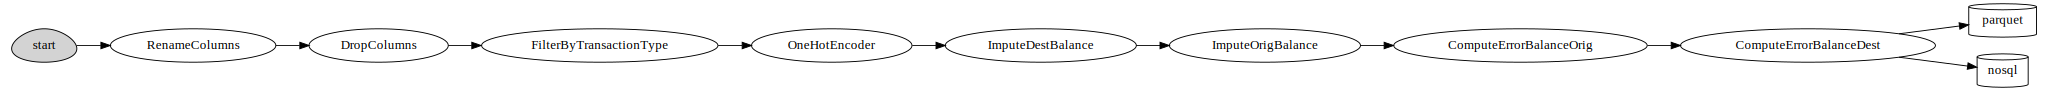

In [5]:
fraud_detection_set.plot(rankdir="LR", with_targets=True)

### Ingest into Feature Store

In [6]:
df = pd.read_csv('data/transactions_sample.csv')

In [7]:
resp = fs.ingest(featureset=fraud_detection_set,
                 source=df,
                 infer_options=fs.InferOptions.default())

### Example Feature Vector

##### Training Set

In [8]:
features = ['fraud_detection_set.step',
            'fraud_detection_set.type_TRANSFER',
            'fraud_detection_set.type_CASH_OUT',
            'fraud_detection_set.amount',
            'fraud_detection_set.oldBalanceOrig',
            'fraud_detection_set.newBalanceOrig',
            'fraud_detection_set.oldBalanceDest',
            'fraud_detection_set.newBalanceDest',
            'fraud_detection_set.errorBalanceOrig',
            'fraud_detection_set.errorBalanceDest']

vector = fs.FeatureVector("fraud-detection-train", features)

In [9]:
resp = fs.get_offline_features(vector)
df = resp.to_dataframe()
df

,step,type_TRANSFER,type_CASH_OUT,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest
transaction_id,,,,,,,,,,
6d6ef9d2-8e81-481e-b221-8140a29a9c97,1,1,0,181.00,181.00,0.0,-1.0,-1.00,0.00,181.00
a9dae5ae-584a-44de-9b75-433f774cce1d,1,0,1,181.00,181.00,0.0,21182.0,0.00,0.00,21363.00
bbd499c7-20ca-40f7-9a20-cfa9bdbf9231,1,0,1,229133.94,15325.00,0.0,5083.0,51513.44,213808.94,182703.50
f55b5fe9-aa0b-4890-9716-268cef4a9d90,1,1,0,215310.30,705.00,0.0,22425.0,0.00,214605.30,237735.30
9bf02e2c-4e64-4f8e-9711-7f50911b569a,1,1,0,311685.89,10835.00,0.0,6267.0,2719172.89,300850.89,-2401220.00
fffa0dc3-d991-4617-8ef0-7d4e353a6e29,1,0,1,110414.71,26845.41,0.0,288800.0,2415.16,83569.30,396799.55
f39a1d43-b586-4bf3-bec4-165768730d65,1,0,1,56953.90,1942.02,0.0,70253.0,64106.18,55011.88,63100.72
3352039b-6f4f-4887-978f-9042de6884bd,1,0,1,5346.89,NaN,NaN,652637.0,6453430.91,NaN,-5795447.02


##### Target Set

In [12]:
features = ['fraud_detection_set.isFraud']
vector = fs.FeatureVector("fraud-detection-target", features)

In [13]:
resp = fs.get_offline_features(vector)
df = resp.to_dataframe()
df

,isFraud
transaction_id,
6d6ef9d2-8e81-481e-b221-8140a29a9c97,1
a9dae5ae-584a-44de-9b75-433f774cce1d,1
bbd499c7-20ca-40f7-9a20-cfa9bdbf9231,0
f55b5fe9-aa0b-4890-9716-268cef4a9d90,0
9bf02e2c-4e64-4f8e-9711-7f50911b569a,0
fffa0dc3-d991-4617-8ef0-7d4e353a6e29,0
f39a1d43-b586-4bf3-bec4-165768730d65,0
3352039b-6f4f-4887-978f-9042de6884bd,0
